# CMSSW Emulator

In this exercise you will be guided through the steps to create, compile, and run the emulator of the hls4ml model you trained in part 2. The code in these steps should be executed from the command line on `lxplus` after doing `source setup.sh` from this `cms_mlatl1t_tutorial`.

When developing your own hls4ml NN emulators, you should compile and run your model emulator locally before delivering it to `cms-hls4ml`.

**Note** you need to run the steps described below in the terminal before going through the cells in this notebook!

## Prerequisite

You will need the HLS for the model of part 2.

## 1.

Copy the NN-specific part of the hls4ml project to the `cms-hls4ml` repo. We _don't_ copy `ap_types` since we'll reference them from the externals.

```shell
[ ! -d $MLATL1T_DIR/part3/cms-hls4ml/L1TMLDemo/L1TMLDemo_v1/NN ] && mkdir $MLATL1T_DIR/part3/cms-hls4ml/L1TMLDemo/L1TMLDemo_v1/NN
cp -r $MLATL1T_DIR/part2/L1TMLDemo_v1/firmware/{*.h,*.cpp,weights,nnet_utils} $MLATL1T_DIR/part3/cms-hls4ml/L1TMLDemo/L1TMLDemo_v1/NN
```

## 2.

As of `hls4ml` `0.8.1`, when run outside of Vivado HLS, the C++ code loads the weights from txt files. We need to force compilation of the weights from the header file instead. 

This one liner will replace the `#define` that would cause the weights to be loaded from txt files with one that will load them from the header files when we compile instead.

If you don't do this, when you `cmsRun` you will see a runtime error like `ERROR: file w2.txt does not exist`

```shell
find $MLATL1T_DIR/part3/cms-hls4ml/L1TMLDemo/L1TMLDemo_v1/NN \( -type d -name .git -prune \) -o -type f -print0 | xargs -0 sed -i 's/#ifndef __SYNTHESIS__/#ifdef __HLS4ML_LOAD_TXT_WEIGHTS__/'
```

## 3.

`make` the hls4ml emulator interface shared object

```shell
cd $MLATL1T_DIR/part3/cms-hls4ml/hls4mlEmulatorExtras
make
mkdir lib64
mv libemulator_interface.so lib64
```

## 4.

`make` the `L1TMLDemo` model shared object

```shell
cd $MLATL1T_DIR/part3/cms-hls4ml/L1TMLDemo
make
```

*Note* you might benefit from adding `-g` to `CXXFLAGS` to compile with debugging while developing.
The Makefile line would change to `CXXFLAGS := -O3 -fPIC -std=$(CPP_STANDARD) -g`.


## 5.

`scram build` compile the CMSSW code

```shell
cd $CMSSW_BASE/src
scram b -j8
```

## 6.

Copy the `L1TMLDemo` model shared object to the CMSSW area.

```shell
mkdir $CMSSW_BASE/src/L1Trigger/L1TMLDemo/data
cp $MLATL1T_DIR/part3/cms-hls4ml/L1TMLDemo/L1TMLDemo_v1.so $CMSSW_BASE/src/L1Trigger/L1TMLDemo/data
```

## 7.

Run the test config over signal and background!

```shell
cd $CMSSW_BASE/src/L1Trigger/L1TMLDemo/test
cmsRun demoL1TMLNtuple.py signal=True
cmsRun demoL1TMLNtuple.py signal=False
```

We run over the same datasets as part 1:
- Signal: `/GluGlutoHHto2B2Tau_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV_powheg-pythia8/Run3Summer22MiniAODv4-130X_mcRun3_2022_realistic_v5-v2/MINIAODSIM`
- Background: `/SingleNeutrino_E-10-gun/Run3Summer23BPixMiniAODv4-130X_mcRun3_2023_realistic_postBPix_v2-v2/MINIAODSIM`

This will produce the files
- `L1TMLDemo_NanoAOD_signal.root`
- `L1TMLDemo_NanoAOD_background.root`

*Note* when developing your own models, you may unfortunately run into segmentation violations while developing. The most common reason is that the input and output data type set in the producer mismatch the types used by the model emulator. In this emulator workflow, this causes a runtime error rather than a compile time error.

## 8.

Run the notebook part3.ipynb

# Notebook

Now we can read the predictions from our Nano AOD ntuple and check they make sense compared to part 1 and part 2.

In [1]:
import numpy as np
import uproot
import awkward as ak
import matplotlib.pyplot as plt
import mplhep
import os
d = os.environ['MLATL1T_DIR']

## Load data
Load our signal and background data with `uproot`

In [2]:
f_sig = uproot.open(d + '/part3/cmssw/src/L1Trigger/L1TMLDemo/test/L1TMLDemo_NanoAOD_signal.root')
f_bkg = uproot.open(d + '/part3/cmssw/src/L1Trigger/L1TMLDemo/test/L1TMLDemo_NanoAOD_background.root')
y_sig_cmssw = ak.flatten(f_sig['Events/L1TMLDemo_y'].array()).to_numpy()
y_bkg_cmssw = ak.flatten(f_bkg['Events/L1TMLDemo_y'].array()).to_numpy()

## Histogram

Plot the score distribution for signal and background

In [3]:
bins=np.linspace(0, 1, 100)
w = bins[1]
h_sig, _ = np.histogram(y_sig_cmssw, bins=bins)
h_bkg, _ = np.histogram(y_bkg_cmssw, bins=bins)
h_sig = h_sig.astype('float') / np.sum(h_sig)
h_bkg = h_bkg.astype('float') / np.sum(h_bkg)

## Plot

/afs/cern.ch/user/s/ssummers/.local/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/afs/cern.ch/user/s/ssummers/.local/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


Text(0, 0.5, 'Frequency')

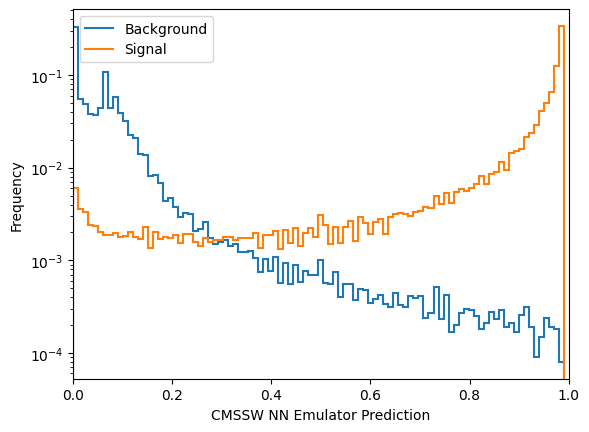

In [4]:
mplhep.histplot(h_bkg, bins, label='Background')
mplhep.histplot(h_sig, bins, label='Signal')
plt.semilogy()
plt.legend()
plt.xlim(0,1)
plt.xlabel('CMSSW NN Emulator Prediction')
plt.ylabel('Frequency')